# Análisis y procesamiento de señales - Trabajo semanal Nº5
# Aramayo Yohana Valentina #

Se pide:

1) Realizar la estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

2) Realice una estimación del ancho de banda de cada señal y presente los resultados en un tabla para facilitar la comparación.



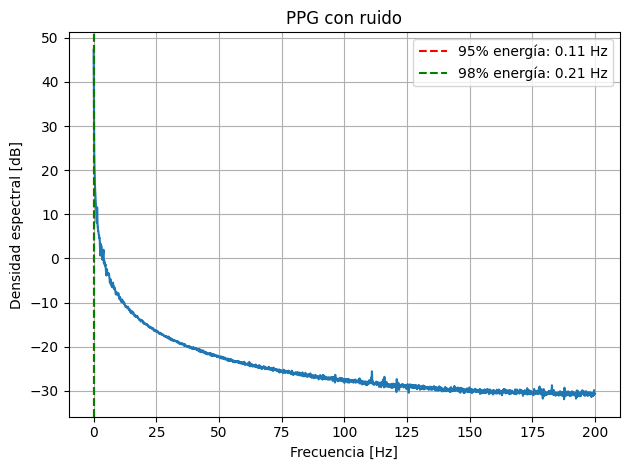

Frecuencia al 95% de la energía acumulada: 0.11 Hz
Frecuencia al 98% de la energía acumulada: 0.21 Hz


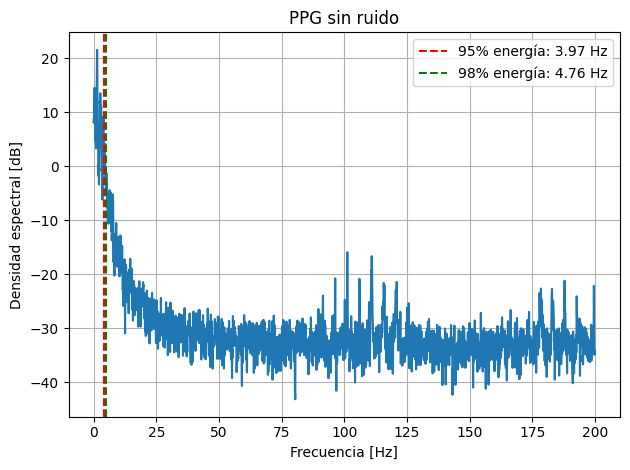

Frecuencia al 95% de la energía acumulada: 3.97 Hz
Frecuencia al 98% de la energía acumulada: 4.76 Hz


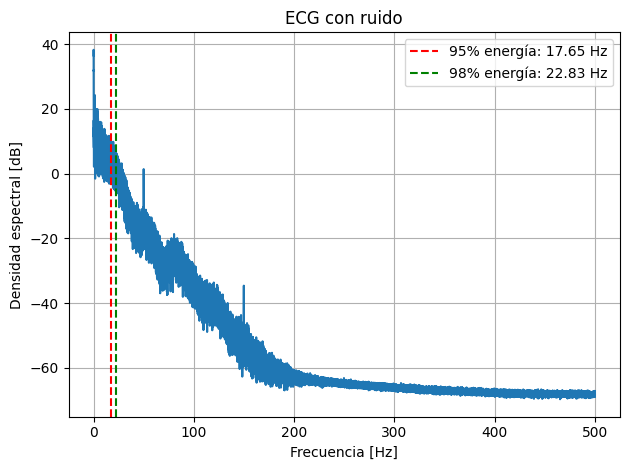

Frecuencia al 95% de la energía acumulada: 17.65 Hz
Frecuencia al 98% de la energía acumulada: 22.83 Hz


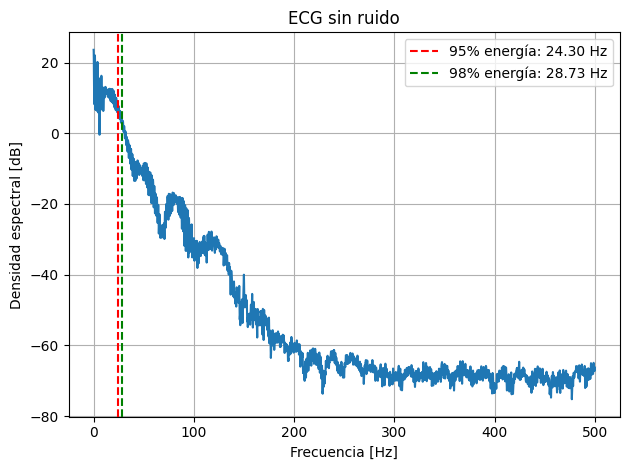

Frecuencia al 95% de la energía acumulada: 24.30 Hz
Frecuencia al 98% de la energía acumulada: 28.73 Hz


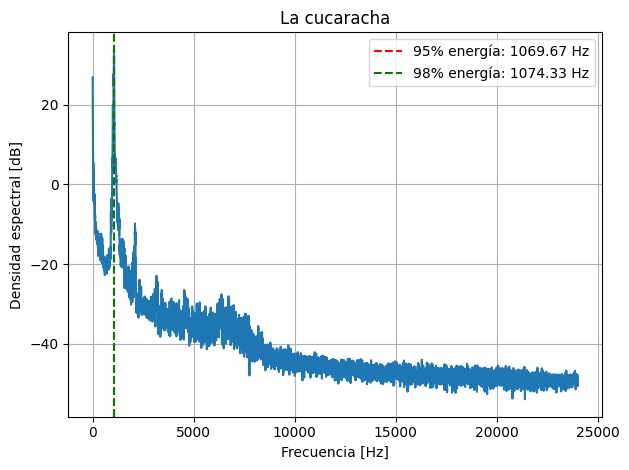

Frecuencia al 95% de la energía acumulada: 1069.67 Hz
Frecuencia al 98% de la energía acumulada: 1074.33 Hz


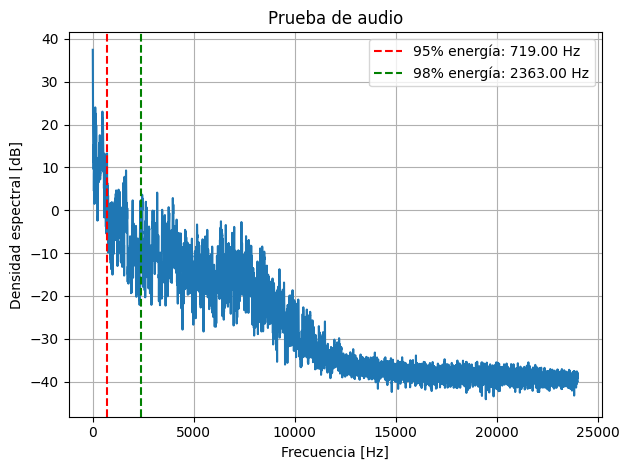

Frecuencia al 95% de la energía acumulada: 719.00 Hz
Frecuencia al 98% de la energía acumulada: 2363.00 Hz


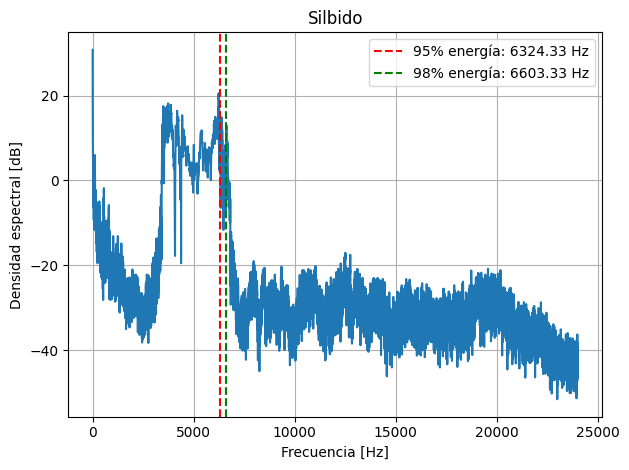

Frecuencia al 95% de la energía acumulada: 6324.33 Hz
Frecuencia al 98% de la energía acumulada: 6603.33 Hz


,Ancho de Banda al 95% [Hz],Ancho de Banda al 98% [Hz]
ECG c/ruido,17.65,22.83
ECG s/ruido,24.30,28.73
PPG c/ruido,0.11,0.21
PPG s/ruido,3.97,4.76
La cucaracha,1069.67,1074.33
Prueba de audio,719.00,2363.00
Silbido,6324.33,6603.33


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat May 10 10:59:23 2025

@author: Vale
"""

import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io.wavfile import write, read
import pandas as pd

def vertical_flaten(a):
    return a.reshape(a.shape[0],1)

def blackman_tukey(x,  M = None):    
    x_z = x.shape
    N = np.max(x_z)
    
    if M is None:
        M = N//5
    
    r_len = 2*M-1

    # Aplanar los arrays para np.correlate.
    xx = x.ravel()[:r_len]

    r = np.correlate(xx, xx, mode='same') / r_len

    Px = np.abs(np.fft.fft(r * sig.windows.blackman(r_len), n = N) )
    Px = Px.reshape(x_z)

    return Px;

def procesar_señal(señal, fs, titulo="PSD de la señal", es_silbido=False):
    """
    Procesa una señal: normaliza, calcula PSD por Blackman-Tukey, grafica y devuelve info clave.
    Parámetros:
    - señal: array con la señal a analizar
    - fs: frecuencia de muestreo
    - titulo: título para el gráfico
    - es_silbido: si es True, usa M = N//4 en Blackman-Tukey para mejor resolución en tonos puros
    """

    señal = señal / np.std(señal)
    N = len(señal)

    if es_silbido:
        M = N // 4
    else:
        M = N // 10

    df = fs / N
    ff = np.linspace(0, fs, N, endpoint=False)

    psd = blackman_tukey(señal, M)

    # Cálculo de energía acumulada
    psd_half = psd[:N//2].ravel()
    ff_half = ff[:N//2]

    energia_total = np.sum(psd_half)
    energia_acumulada = np.cumsum(psd_half) / energia_total
    indice_95 = np.where(energia_acumulada >= 0.95)[0][0]
    f_95 = ff_half[indice_95]
    indice_98 = np.where(energia_acumulada >= 0.98)[0][0]
    f_98 = ff_half[indice_98]

    # Gráfico
    plt.plot(ff[:N//2], 10 * np.log10(np.abs(psd[:N//2]) + 1e-10))
    plt.axvline(x=f_95, color='r', linestyle='--', label=f'95% energía: {f_95:.2f} Hz')
    plt.axvline(x=f_98, color='green', linestyle='--', label=f'98% energía: {f_98:.2f} Hz')
    plt.title(titulo)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Densidad espectral [dB]')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Frecuencia al 95% de la energía acumulada: {f_95:.2f} Hz")
    print(f"Frecuencia al 98% de la energía acumulada: {f_98:.2f} Hz")

    return psd, ff, f_95, f_98, energia_total, energia_acumulada

#%%

####################################
# Lectura de pletismografía (PPG)  #
####################################

fs_ppg = 400 # Hz

##################
## PPG con ruido##
##################

ppg_c_ruido = np.genfromtxt('PPG.csv', delimiter=',', skip_header=1)  # Omitir la cabecera si existe
psd_c, ff_c, f_95_c_ppg, f_98_c_ppg, energia_tot_c, energia_acum_c = procesar_señal(ppg_c_ruido, fs=400, titulo="PPG con ruido")

##################
## PPG sin ruido
##################

ppg_s_ruido = np.load('ppg_sin_ruido.npy')
psd_s_ppg, ff_s_ppg, f_95_s_ppg, f_98_s_ppg, energia_tot_s_ppg, energia_acum_s_ppg = procesar_señal(ppg_s_ruido, fs=400, titulo="PPG sin ruido")

##################
## ECG con ruido
##################

mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_c_ruido = vertical_flaten(mat_struct['ecg_lead'])
ecg_c_ruido = mat_struct['ecg_lead'].reshape(-1, 1)

psd_c_ecg, ff_c_ecg, f_95_c_ecg, f_98_c_ecg, energia_tot_c_ecg, energia_acum_c_ecg = procesar_señal(ecg_c_ruido, fs=1000, titulo="ECG con ruido")

##################
## ECG sin ruido
##################

ecg_s_ruido = np.load('ecg_sin_ruido.npy')
psd_s_ecg, ff_s_ecg, f_95_s_ecg, f_98_s_ecg, energia_tot_s_ecg, energia_acum_s_ecg = procesar_señal(ecg_s_ruido, fs=1000, titulo="ECG sin ruido")

####################
# Lectura de audio #
####################

fs_audio, wav_data = read('la cucaracha.wav')
if wav_data.ndim > 1:
    wav_data = wav_data[:, 0]
wav_data = wav_data.astype(np.float64)
psd_cuca, ff_cuca, f_95_cuca, f_98_cuca, energia_tot_cuca, energia_acum_cuca = procesar_señal(wav_data, fs_audio, titulo="La cucaracha")

fs_audio2, wav_data2 = read('prueba psd.wav')
if wav_data2.ndim > 1:
    wav_data2 = wav_data2[:, 0]
wav_data2 = wav_data2.astype(np.float64)
psd_prueba, ff_prueba, f_95_prueba, f_98_prueba, energia_tot_prueba, energia_acum_prueba = procesar_señal(wav_data2, fs_audio2, titulo="Prueba de audio")

fs_audio3, wav_data3 = read('silbido.wav')
if wav_data3.ndim > 1:
    wav_data3 = wav_data3[:, 0]
wav_data3 = wav_data3.astype(np.float64)
psd_silbido, ff_silbido, f_95_silbido, f_98_silbido, energia_tot_silbido, energia_acum_silbido= procesar_señal(wav_data3, fs_audio3, titulo="Silbido", es_silbido=True)

# Crear tabla de resultados
tabla = pd.DataFrame({
    "Ancho de Banda al 95% [Hz]": [
        f_95_c_ecg,
        f_95_s_ecg,
        f_95_c_ppg,
        f_95_s_ppg,
        f_95_cuca,
        f_95_prueba,
        f_95_silbido
    ],
    "Ancho de Banda al 98% [Hz]": [
        f_98_c_ecg,
        f_98_s_ecg,
        f_98_c_ppg,
        f_98_s_ppg,
        f_98_cuca,
        f_98_prueba,
        f_98_silbido
    ]
}, index=[
    "ECG c/ruido",
    "ECG s/ruido",
    "PPG c/ruido",
    "PPG s/ruido",
    "La cucaracha",
    "Prueba de audio",
    "Silbido"
])

# Estilo para la tabla
tabla.style.set_caption("Estimación de Ancho de Banda al 95% y 98% de Energía") \
     .format("{:.2f}") \
     .set_table_styles([{
         "selector": "caption",
         "props": [("font-size", "16px"), ("font-weight", "bold")]
     }])


# ANÁLISIS
La estimación de la densidad espectral de potencia (PSD) las realicé con el Método de Blackman Tuckey. Decidí usar este método porque ofrece una estimación más suave y con menor varianza que el periodograma clásico (sin ventanear). Además, permite controlar explícitamente la resolución espectral mediante la elección del tamaño de ventana.
 
Un comentario general que hago antes de empezar a analizar señal por señal es sobre el cambio al estimar la densidad espectral de potencia de una señal con ruido y sin este. Por ejemplo, en el caso de ppg la señal sin ruido muestra oscilaciones o picos más marcados, reflejando con mayor claridad sus componentes frecuenciales. En cambio, la señal ruidosa presenta un espectro más uniforme. Esto se debe a que el ruido, especialmente si es blanco, introduce energía en todo el espectro, enmascarando las características propias de la señal original. 

## ESTIMACIÓN DEL ANCHO DE BANDA 

El ancho de banda de una señal puede definirse a partir de su densidad espectral de potencia (PSD) como el ancho de banda de energía, que corresponde al intervalo de frecuencias dentro del cual se concentra un cierto porcentaje de la energía total de la señal. 
En este caso, para estimar el ancho de banda de cada señal, observamos en qué rango de frecuencias se concentra el 95% y el 98% de la energía total de la señal. Para ello, integramos la densidad espectral de potencia (PSD) en el dominio de la frecuencia, comenzando desde 0 Hz, y acumulamos progresivamente la energía en una variable. Con el objetivo de identificar manualmente el rango que contiene el 95% y 98% de la energía, se normalizó la energía acumulada dividiéndola por la energía total. De esta forma, se observó fácilmente el porcentaje acumulado de energía correspondiente a cada bin de frecuencia.

Las ventajas de estimar el ancho de banda de esta manera radican en el hecho de que es un método rápido de implementar y sencillo,lo cual lo hace adecuado para análisis exploratorios o comparativos entre señales. Sin embargo, el método también presenta algunas limitaciones. Una de ellas es la posibilidad de sobreestimar el ancho de banda cuando hay ruido presente en frecuencias altas, ya que este puede contribuir artificialmente a la energía total acumulada, extendiendo el rango necesario para alcanzar el 95% o 98%. Del mismo modo, si la señal contiene ruido en bajas frecuencias, este puede llevar a una subestimación del ancho de banda, ya que la energía acumulada se empieza a incrementar desde frecuencias donde la señal real no tiene componentes significativos.
Luego, si la señal no contiene energía en las bajas frecuencias pero se considera el ancho de banda desde 0 Hz, se corre el riesgo de sobreestimar el ancho de banda útil, ya que se incluyen frecuencias que no aportan contenido real. Esto resalta la importancia de interpretar cuidadosamente los resultados, especialmente cuando hay presencia de ruido o la señal no ocupa todo el espectro desde frecuencias muy bajas.
Algunas de las limitaciones se pueden observar al comparar la estimacion del ancho de banda estimado para una señal con y sin ruido. En el caso de las señales de ECG y PPG, la presencia de ruido tiende a subestimar el ancho de banda. Esto ocurre porque el ruido introduce energía en frecuencias bajas, haciendo que el 95% de la energía acumulada se alcance más rápidamente, es decir, a frecuencias menores. Como consecuencia, el rango de frecuencias considerado como ancho de banda es más reducido de lo que realmente debería ser, ya que incluye energía que no proviene de la señal original.

### ECG
Se analizó la señal de ECG con y sin ruido mediante la estimación de su densidad espectral de potencia (PSD). En la señal ruidosa se observa un pico en bajas frecuencias, probablemente asociado a interferencias de cables, movimientos del paciente o artefactos ambientales. Además, se detecta un pico en 50 Hz, correspondiente al ruido de la red eléctrica. Es conveniente aplicar un filtro notch centrado en 50 Hz, ya que este pico no aporta información relevante sobre la señal fisiológica.
Al comparar las PSD con y sin ruido, se observa que la señal filtrada presenta menor energía total y ya no muestra el pico en bajas frecuencias. Esto indica que el ruido estaba concentrado principalmente en ese rango. Como consecuencia, la estimación del ancho de banda basada en el 95% de la energía acumulada puede verse afectada: en la señal con ruido, se tiende a subestimar el ancho de banda real debido a la energía espuria en frecuencias bajas. En cambio, en la señal limpia la estimación resulta más representativa de las componenetes freucenciales de la señal

El ancho de banda de ECG va desde 0,5 a 35 Hz aproximadamente. En las estimaciones de ancho de banda vemos que obtenemos una mejor estimación para ECG sin ruido, lo que es esperable según lo analizado previamente. 

### PPG
Un PPG ( Fotopletismograma) es una señal biológica que mide cambios en el volumen sanguíneo a través de un sensor óptico. Se usa comúnmente en dispositivos como relojes inteligentes, oxímetros y monitores de pulso.

#### Diferencia entre señal con y sin ruido
Al igual que en el caso del ecg, la señal con ruido tiene mucha más energía que sin ruido a frecuencias bajas hay una diferencia de aproximadamente 20db entre las señales.

Estimación del Ancho de banda
El ancho de banda de PPG va desde 0,1 a 10 Hz según lo charlado en clase. Se trata de un rango de bajas frecuencias.
El ancho de banda obtenido con ruido no alcanza siquiera 1Hz. Esto denota una alta contaminación de la señal con ruido a muy baja frecuencia, pues la energía del ruido hace que la energía al 95% se concentre a unos décimos de Hz. Luego, al estimar el ancho de banda para la señal sin ruido se obtiene un ancho de banda de 3 Hz para el 95% y 4 Hz para el 98%. Una estimación bastante buena pues los primeros 5 Hz de un PPG. Las frecuencias se encuentran dentro del rango propuesto. Parece un método adecuado de utilizar en este caso, considerando que el ancho de banda de la señal arranca en 0,1Hz aproximadamente.

### AUDIO
En esta tarea se trabajó con tres audios. El primero es la canción conocida como La Cucaracha, interpretada mediante un silbido. El segundo es una grabación de audio del profesor hablando en un tono normal. Finalmente, el tercero corresponde a un silbido en tono agudo. Las tres señales son bastante limpias debido a que no contienen ruido de fondo ni interferencias significativas.

En el caso de la canción se obtiene un ancho de banda de aproximadamente 1050 Hz. Luego, para el caso de la prueba de audio tenemos una frecuencia de 2000 Hz. Finalmente, tenemos un ancho de banda para el silbido de 6Khz. Tiene mucho sentido el ancho obtenido para el silbido ya que al tratarse de tonos agudos seguro debíamos obtener energía en frecuencias altas. En cuanto a la prueba de audio también tenemos buenos resultado ya que la voz humana normal se encuentra en un rango de 500 a 2000 Hz que es lo que obtenemos. Lo último que queda por analizar es el ancho de banda para la cucaracha. El silbido de una persona puede variar mucho en frecuencia, típicamente entre 1 kHz y 8 kHz, dependiendo de la técnica y la voz del individuo. Por eso, un resultado alrededor de 1000 Hz es posible si el silbido es más bajo.

